In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import os

AudioSegment.converter = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
AudioSegment.ffmpeg = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
AudioSegment.ffprobe = r"C:\tools\ffmpeg-master-latest-win64-gpl\bin\ffprobe.exe"

DATASET_BASE_FILE_PATH = r"D:\kaggle_competition\birdclef-2023"
TRAIN_SET_FILE_DIR = r"\train_audio"
TEST_SET_FILE_DIR = r"\test_soundscapes"
SAMPLE_SUBMISSION_FILE_PATH = r"\sample_submission.csv"

train_metadata = pd.read_csv(DATASET_BASE_FILE_PATH + r"\train_metadata.csv")
sample_submission = pd.read_csv(DATASET_BASE_FILE_PATH + SAMPLE_SUBMISSION_FILE_PATH)
ebird_taxonomy = pd.read_csv(DATASET_BASE_FILE_PATH + r"\ebird_Taxonomy_v2021.csv")


# Data exploration

In [20]:
train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [21]:
sample_submission.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
ebird_taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


## Distribution of Bird Species

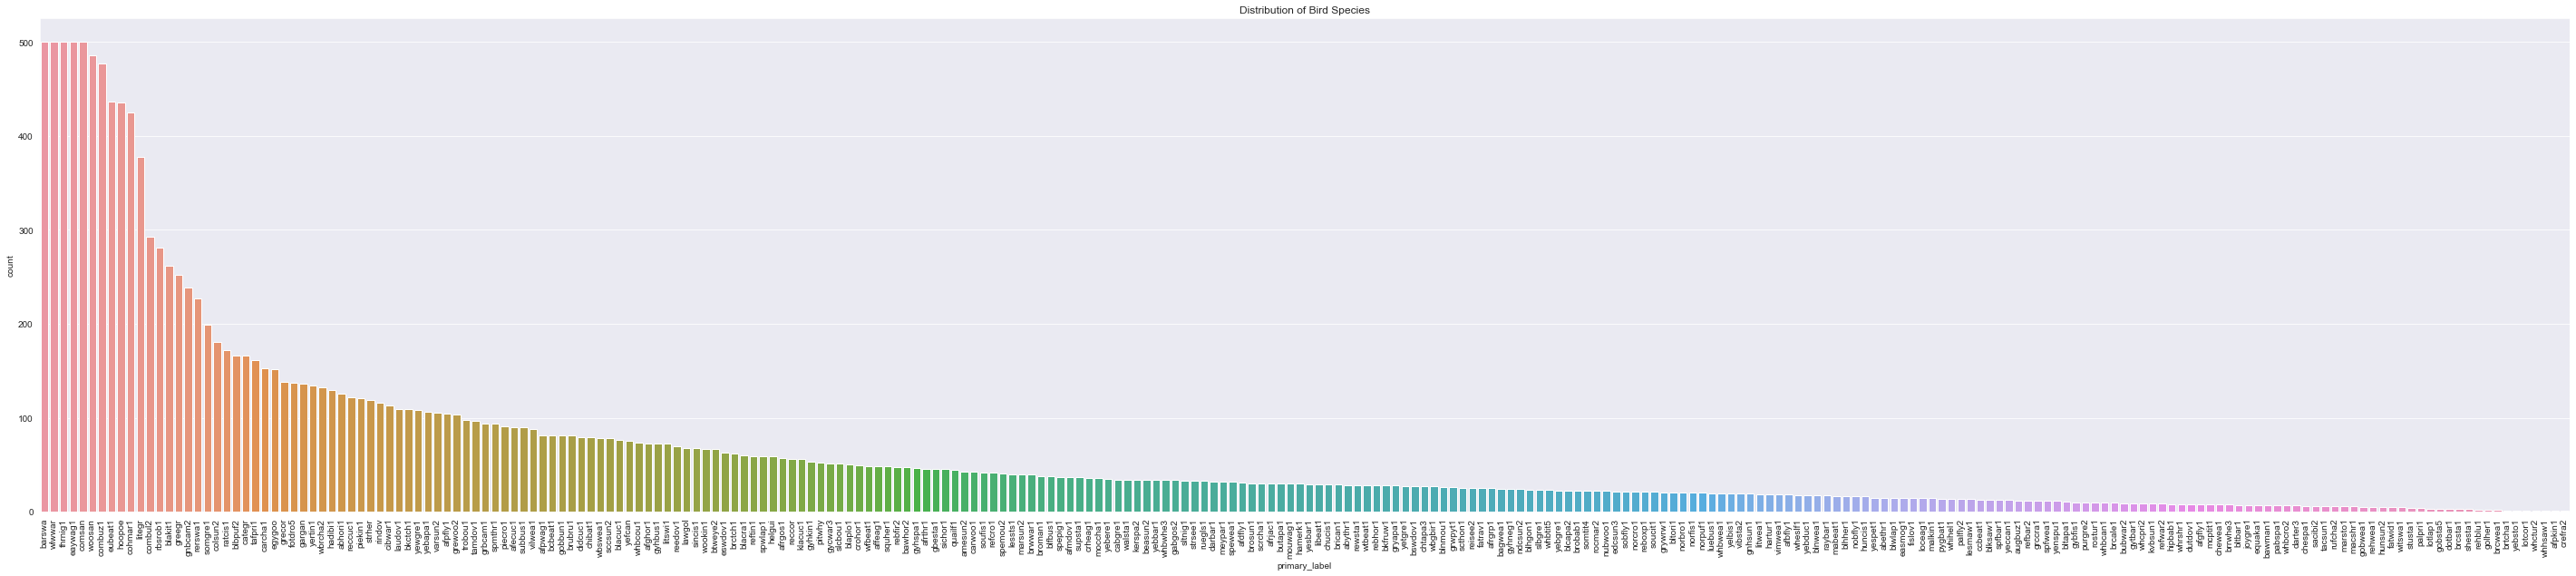

In [23]:
plt.figure(figsize=(50, 10))
sns.countplot(data=train_metadata, x='primary_label', order=train_metadata['primary_label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Bird Species')
plt.show()

## Geographic distribution

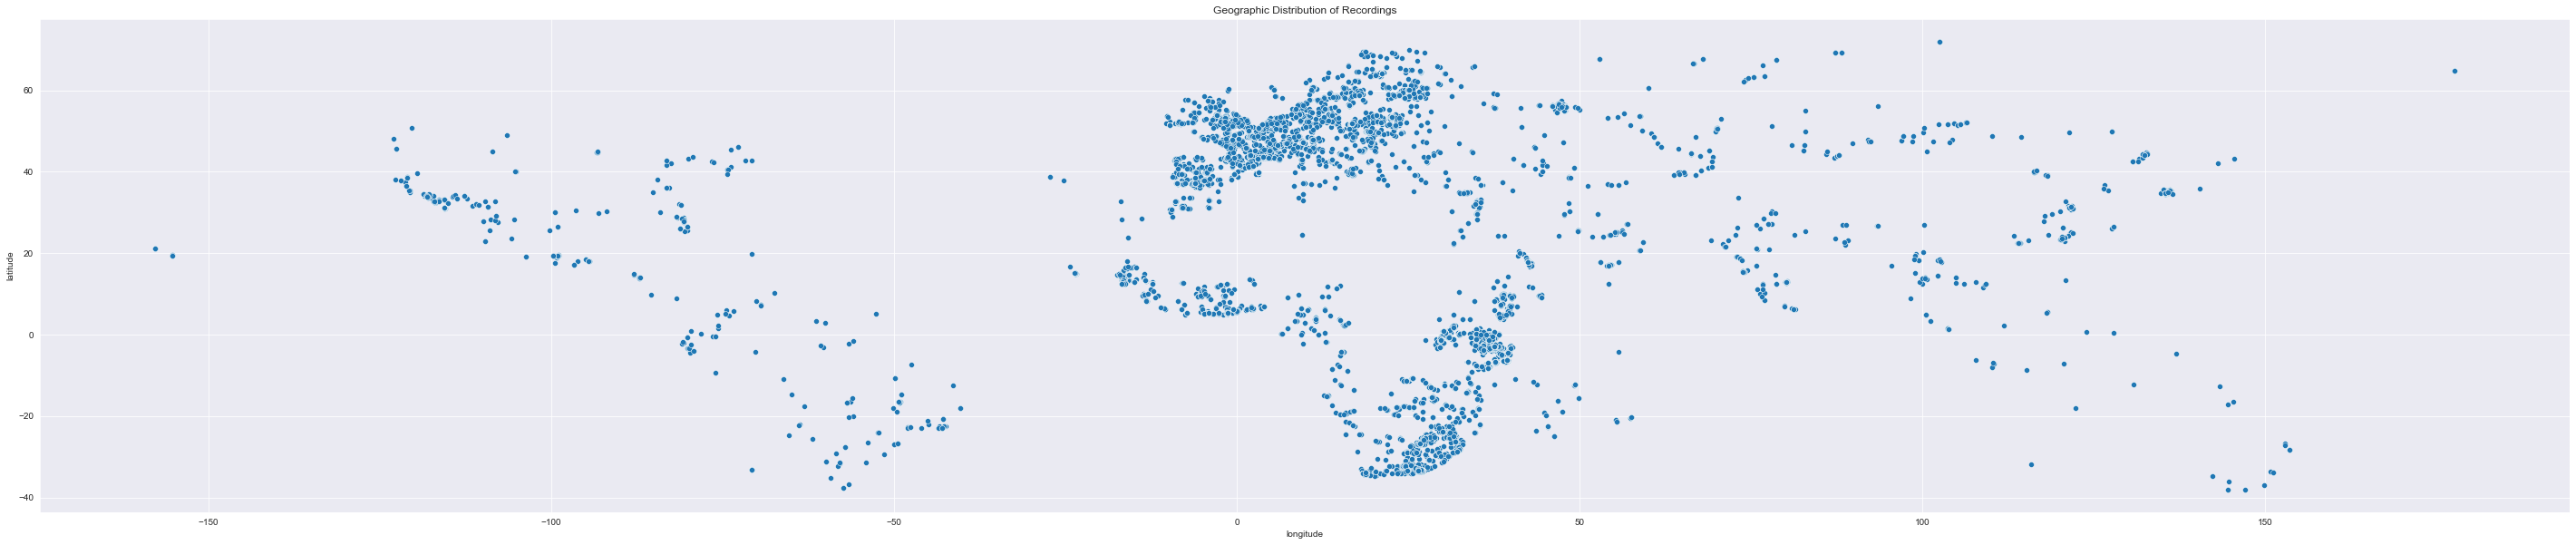

In [24]:
plt.figure(figsize=(50, 10))
sns.scatterplot(data=train_metadata, x='longitude', y='latitude')
plt.title('Geographic Distribution of Recordings')
plt.show()

## Distribution of Recordings by Author

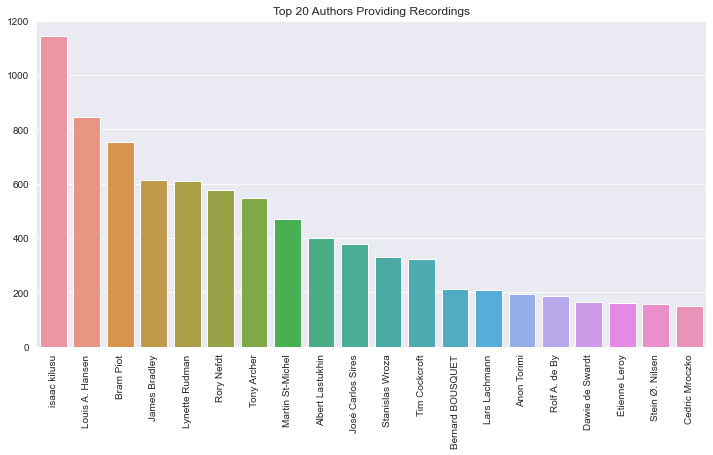

In [25]:
def plot_author_distribution(train_metadata):
    plt.figure(figsize=(12, 6))
    top_authors = train_metadata['author'].value_counts().head(20)
    sns.barplot(x=top_authors.index, y=top_authors.values)
    plt.xticks(rotation=90)
    plt.title('Top 20 Authors Providing Recordings')
    plt.show()

plot_author_distribution(train_metadata)

## Distribution of Recording Ratings

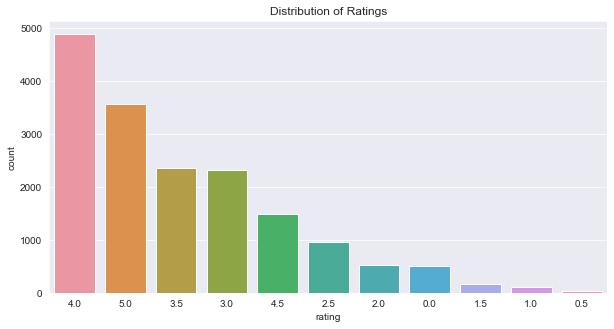

In [26]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_metadata, x='rating', order=train_metadata['rating'].value_counts().index)
plt.title("Distribution of Ratings")
plt.show()

## Explore the distribution of recording types

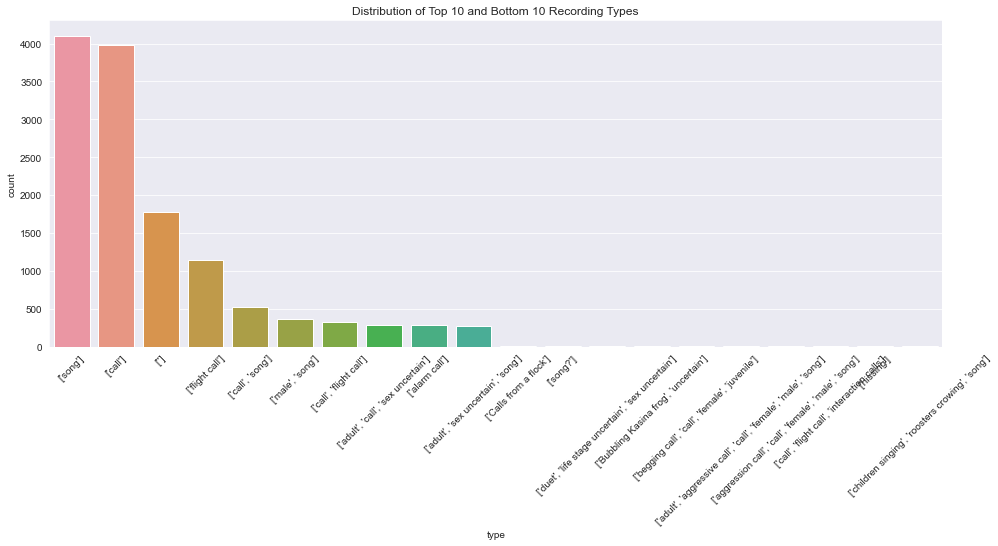

In [36]:
#train_metadata['type'] = train_metadata['type'].apply(lambda x: eval(x))
#train_metadata = train_metadata.explode('type')
#plt.figure(figsize=(50, 5))
#sns.countplot(data=train_metadata, x='type', order=train_metadata['type'].value_counts().index)
#plt.title("Distribution of Recording Types")
#plt.show()

# Get the top 10 most frequent and least frequent recording types
top_10_types = train_metadata['type'].value_counts().nlargest(10).index
bottom_10_types = train_metadata['type'].value_counts().nsmallest(10).index
selected_types = top_10_types.union(bottom_10_types)

# Filter the train_metadata DataFrame to include only the selected types
filtered_train_metadata = train_metadata[train_metadata['type'].isin(selected_types)]

# Plot the selected recording types
plt.figure(figsize=(16, 6))
sns.countplot(data=filtered_train_metadata, x='type', order=filtered_train_metadata['type'].value_counts().index)
plt.title("Distribution of Top 10 and Bottom 10 Recording Types")
plt.xticks(rotation=45)
plt.show()

## Analyze the distribution of bird occurrences by class of latitude and longitude

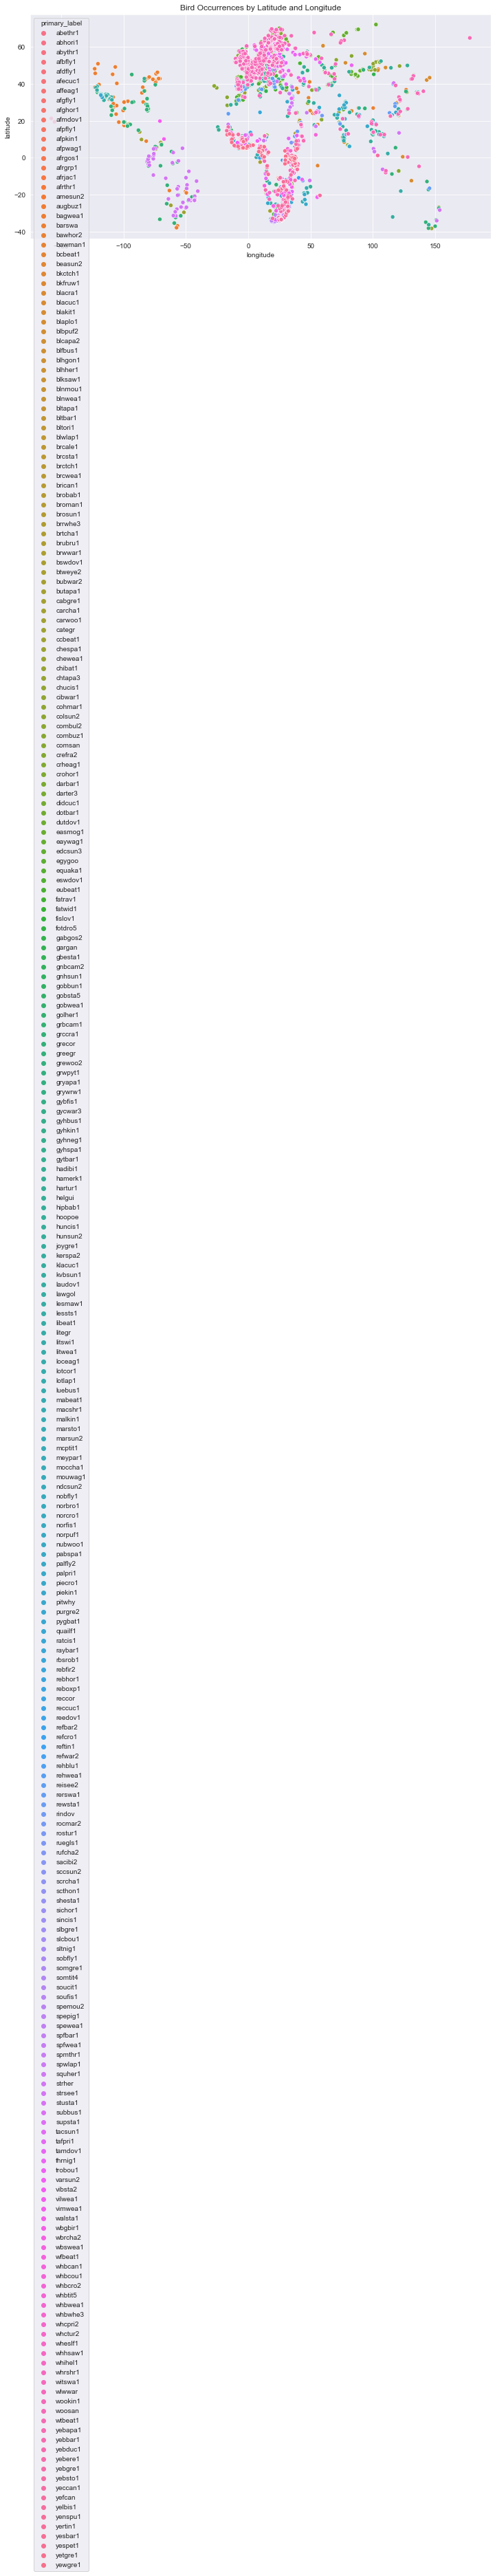

In [30]:
def plot_bird_occurrences_by_lat_long(train_metadata):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=train_metadata, x='longitude', y='latitude', hue='primary_label')
    plt.title('Bird Occurrences by Latitude and Longitude')
    plt.show()
plot_bird_occurrences_by_lat_long(train_metadata)

In [ ]:
## Visualize the distribution of audio file durations

In [31]:
def get_audio_duration(file_path):
    audio = AudioSegment.from_file(file_path)
    return audio.duration_seconds

In [ ]:
train_audio_folder = os.path.join(DATASET_BASE_FILE_PATH, "train_audio")
train_metadata['file_path'] = train_metadata.apply(lambda row: os.path.join(train_audio_folder, row['filename']), axis=1)

durations = []
for file_path in train_metadata['file_path']:
    try:
        duration = get_audio_duration(file_path)
        durations.append(duration)
    except:
        durations.append(None)

train_metadata['duration'] = durations

plt.figure(figsize=(10, 5))
sns.histplot(train_metadata['duration'].dropna(), kde=True)
plt.title("Distribution of Audio File Durations")
plt.show()

C:\Users\phili\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)
